In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:

# Load the dataset using the file name now that we're in the correct directory
file_name = 'Figure_5_data.csv'
df = pd.read_csv(file_name)  # Directly use the file name


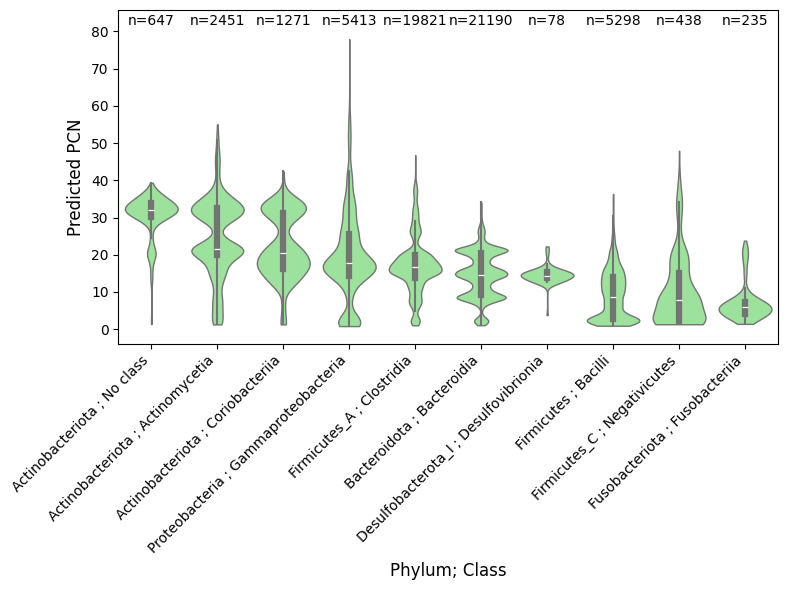

In [ ]:


# 1. Filter and prepare data - using .copy() to avoid SettingWithCopyWarning
df_filtered = df[df['host_taxonomy'].notnull()].copy()

# Function to extract taxonomy
def extract_taxonomy(tax_str):
    parts = tax_str.split(';')
    phylum, class_ = None, None
    for part in parts:
        if part.startswith('p__'): phylum = part.replace('p__', '')
        elif part.startswith('c__'): class_ = part.replace('c__', '')
    return phylum, class_

# Apply the extraction function to get phylum and class
df_filtered[['phylum', 'class']] = df_filtered['host_taxonomy'].apply(
    lambda x: pd.Series(extract_taxonomy(x)))
df_filtered['class'] = df_filtered['class'].fillna('No class')

# 2. Get Engineered ecosystem data
engineered_data = df_filtered[df_filtered['ecosystem_group'] == 'Engineered'].copy()

# 3. Create combined phylum-class labels
engineered_data['phylum_class'] = engineered_data['phylum'] + " / " + engineered_data['class']

# Replace '/' with ';' in the phylum_class column for x-axis labels
engineered_data['phylum_class'] = engineered_data['phylum_class'].str.replace('/', ';')

# 4. Filter data to only include groups with more than 11 plasmids
group_stats = engineered_data.groupby('phylum_class').agg(
    count=('PCN', 'size'),
    median_pcn=('PCN', 'median')
).reset_index()

# Filter for groups with more than 11 plasmids
group_stats_filtered = group_stats[group_stats['count'] > 1]

# 5. Select the top 10 groups based on the highest number of plasmids
top_phylum_class = group_stats_filtered.sort_values('count', ascending=False).head(10)['phylum_class']

# Sort the `top_phylum_class` by **median PCN** in descending order
top_phylum_class_sorted = group_stats_filtered[group_stats_filtered['phylum_class'].isin(top_phylum_class)]
top_phylum_class_sorted = top_phylum_class_sorted.sort_values('median_pcn', ascending=False)['phylum_class']

# 6. Filter original data for these top 10 phylum-class groups
df_top = engineered_data[engineered_data['phylum_class'].isin(top_phylum_class_sorted)].copy()

# 7. Create ordered categories based on median PCN (sorted in descending order)
df_top['phylum_class'] = pd.Categorical(df_top['phylum_class'], categories=top_phylum_class_sorted, ordered=True)

# 8. Create plot with adjusted y-axis
plt.figure(figsize=(8, 6))

# Calculate y-axis padding
y_padding = df_top['PCN'].max() * 0.05  # 5% padding

# Create violin plot with cut=0 to prevent extension beyond data
violin = sns.violinplot(
    data=df_top,
    x='phylum_class',
    y='PCN',
    color='lightgreen',  # New color for Engineered ecosystem
    inner='box',
    linewidth=1,
    density_norm='width',
    order=top_phylum_class_sorted,
    cut=0  # Prevent violins from extending beyond data
)

# 9. Add count annotations
with pd.option_context('mode.chained_assignment', None):
    counts = df_top.groupby('phylum_class', observed=True).size()

for i, phylum_class in enumerate(top_phylum_class_sorted):
    violin.text(i, df_top['PCN'].max() * 1.05, 
             f'n={counts[phylum_class]}', 
             ha='center', 
             fontsize=10)

# 10. Customize plot
plt.xlabel('Phylum; Class', fontsize=12)
plt.ylabel('Predicted PCN', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# 11. Set y-axis limits with negative padding to prevent violins from touching the axis
plt.ylim(bottom=-y_padding, top=df_top['PCN'].max() * 1.1)

# 12. Save the plot in multiple formats
output_filename = 'fig_5B'
plt.savefig(f'{output_filename}.pdf', dpi=1200, format='pdf', bbox_inches='tight')
plt.savefig(f'{output_filename}.svg', dpi=1200, format='svg', bbox_inches='tight')
plt.savefig(f'{output_filename}.tiff', dpi=1200, format='tiff', bbox_inches='tight')

# 13. Display the plot
plt.tight_layout()
plt.show()
